In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from ex_2 import *

from cf_matrix import make_confusion_matrix

%matplotlib inline

In [2]:
seed = 42
np.random.seed(42)
random.seed(42)

# Classificação multi-classe

A tarefa é de classificação. O objetivo é classificar qual o movimento realizado por uma pessoa baseando-se em 561 atributos temporais e espectrais calculados a partir do acelerômetro e do giroscópio de um smartphone.

Os modelos e normalizações serão implementados utilizando-se da biblioteca `sklearn`.

Primeiramente vamos carregar os dados:

In [3]:
x_train = load_features("./har_smartphone/X_train.txt")
x_test = load_features("./har_smartphone/X_test.txt")

y_train = pd.read_csv("./har_smartphone/y_train.txt", header=None).values.flatten()
y_test = pd.read_csv("./har_smartphone/y_test.txt", header=None).values.flatten()

Aqui vemos que a proporção das classes é ligeiramente diferente.

In [4]:
c, count = np.unique(y_train, return_counts=True)
count_df = pd.DataFrame([c, count]).T
count_df.columns = ["Class", "Count"]
count_df["%"] = count_df["Count"]/count_df["Count"].sum()
count_df

,Class,Count,%
0,1,1226,0.166757
1,2,1073,0.145947
2,3,986,0.134113
3,4,1286,0.174918
4,5,1374,0.186888
5,6,1407,0.191376


Os dados serão normalizados para ter média 0 e variância 1, utilizando o normalizador `StandardScaler` da biblioteca `sklearn`.

In [5]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

# Solução 1 - Regressão Logística

A solução escolhida foi utilizar uma Regressão Logística para cada classe, e realizar a inferência aplicando-se a função `softmax` à predição de todos os modelos para se obter as probabilidades condicionais de cada classe, como mostra a figura abaixo. Assim, a solução baseia-se em uma estratégia "one vs all".

A métrica utilizada para avaliação das soluções sera a F1-score macro, ou $Fscore_M$ (escolhida de "A Systematic Analysis of Performance Measures for Classification Tasks”. Information Processing & Management, vol. 45, no. 4, pp. 427-437, 2009."), pois ela realiza o cálculo da F1 score utilizando os valores médios de recall e precision entre as classes. Essa métrica foi escolhida para minimizar o efeito do desbalanceamento de classes.

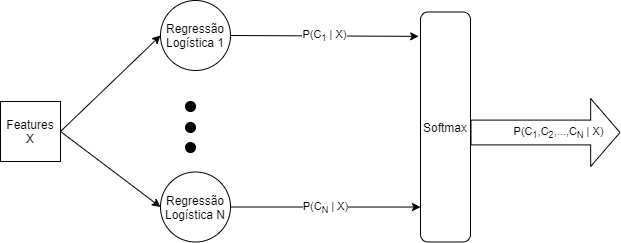

In [6]:
n_classes = len(np.unique(y_train))
model = OVA_LogisticRegression(n_classes)
        
model.fit(x_train_norm, y_train)

metric = macro_f1_score(y_test, model.predict(x_test_norm))

Fitting Logistic Regression for class 1
Fitting Logistic Regression for class 2
Fitting Logistic Regression for class 3
Fitting Logistic Regression for class 4
Fitting Logistic Regression for class 5
Fitting Logistic Regression for class 6


A seguir temos a matriz de confusão deste modelo para o conjunto de teste. A classe com a maior precisão é a classe 0, e a com a pior é a classe 3, a qual é bastante confundida pela classe 4.

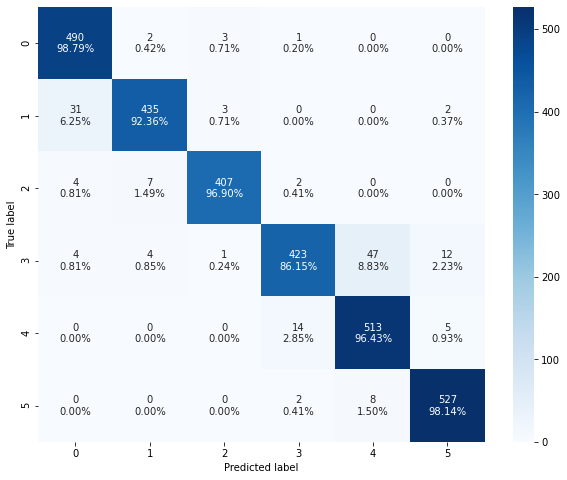

In [7]:
cm = confusion_matrix(y_test, model.predict(x_test_norm))
make_confusion_matrix(cm, sum_stats=False, figsize=(10, 8))

In [8]:
print("Macro F1 score:")
macro_f1_score(y_test, model.predict(x_test_norm))

Macro F1 score:


0.9485833558550635

O valor de F1 score macro obtido para esta primeira solução foi de 0.9486 no conjunto de teste.

# Solução 2 - K-Nearest Neighbours

Para esta solução a normalização será diferente. Será utilizada a transformação de quantil, que realiza um mapeamento dos vetores de features para que sua distribuição seja diferente, neste caso a distribuição uniforme. Isto é feito para que além da normalização dos valores também seja feita uma normalização das distâncias entre os pontos, já que o algoritmo K-nn se baseia no cálculo de distâncias.

Apenas para fins comparativos, também treinaremos os modelos utilizando os dados que foram normalizados utilizando média e desvio padrão.

O peso de cada ponto no algoritmo de votação do K-nn será multiplicado por um fator proporcional ao inverso de sua distãncia, para que pontos distantes do ponto de inferência tenham menos influência na decisão de sua classe.

In [9]:
scaler = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
scaler.fit(x_train)

x_train_norm_qtl = scaler.transform(x_train)
x_test_norm_qtl = scaler.transform(x_test)

O gráfico a seguir mostra a distribuição das 5 primeiras features após a transformação.

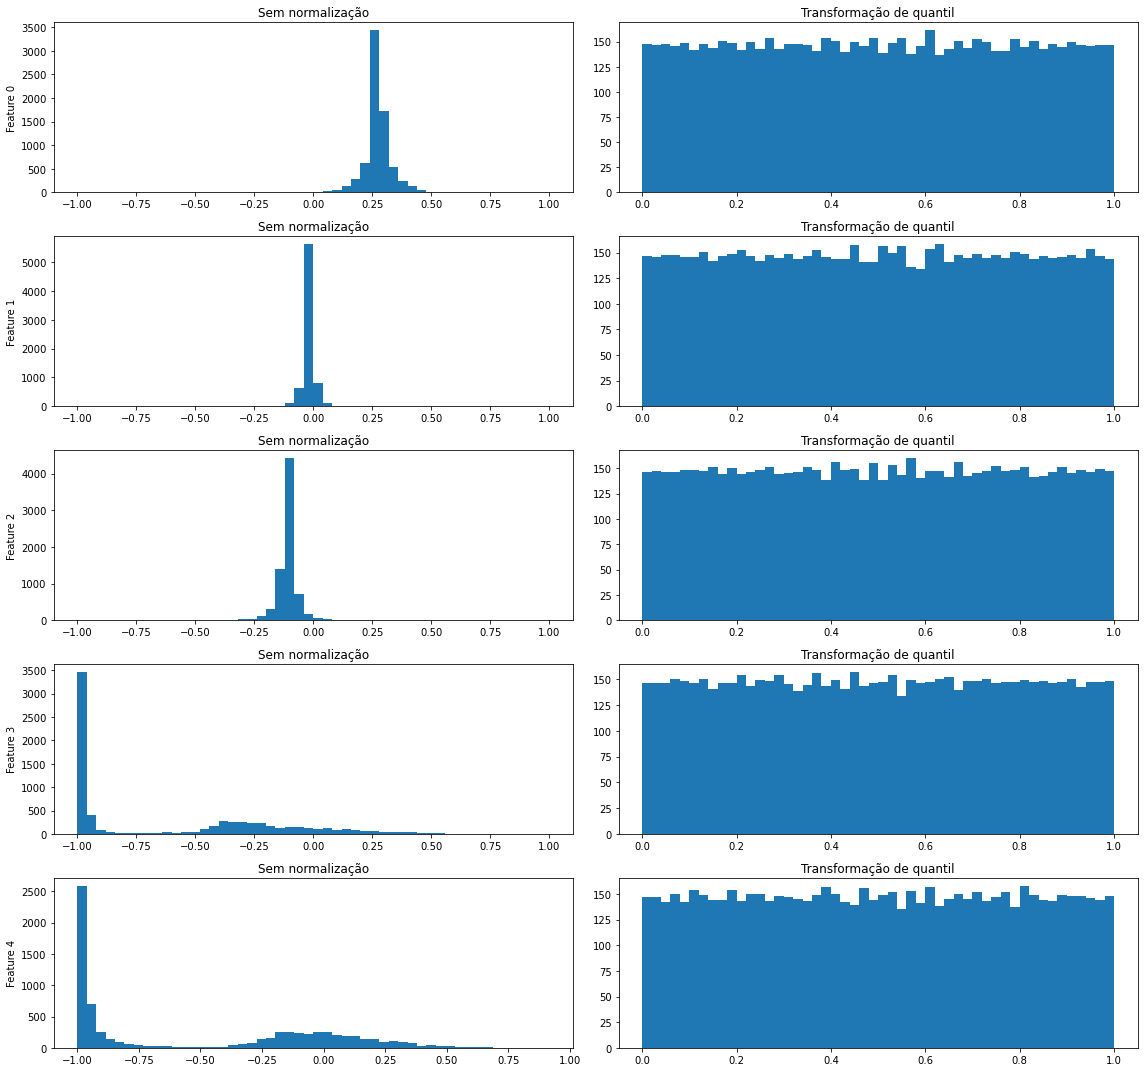

In [10]:
plot_paired_histogram(x_train, x_train_norm_qtl, l2="Transformação de quantil")

O plot a seguir mostra a segunda feature em função da primeira, em um gráfico de dispersão. O plot da esquerda mostra como é essa relação antes da normalização, e o plot da esquerda, após.

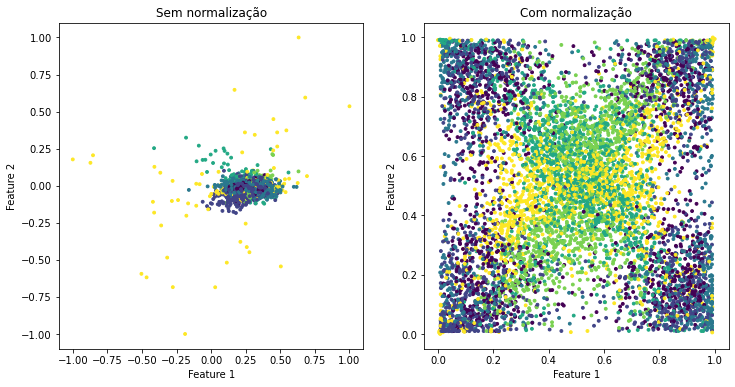

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=8)
axes[1].scatter(x_train_norm_qtl[:, 0], x_train_norm_qtl[:, 1], c=y_train, s=8)

for ax in axes:
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

axes[0].set_title("Sem normalização")
axes[1].set_title("Com normalização");

Iremos avaliar modelos com K variando de 2 à 24, em passos de 2. As matrizes de confusão mostram, além do número de instâncias preditas em cada classe, a precisão do modelo para àquela classe em porcentagem.

K: 2
F1 Macro score using StandardScaler: 0.8508844802966231
F1 Macro score using QuantileTransformer: 0.8691107868003255


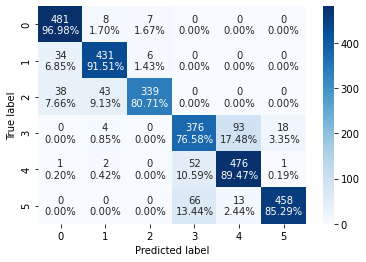

K: 4
F1 Macro score using StandardScaler: 0.8745117500677186
F1 Macro score using QuantileTransformer: 0.8933076638942151


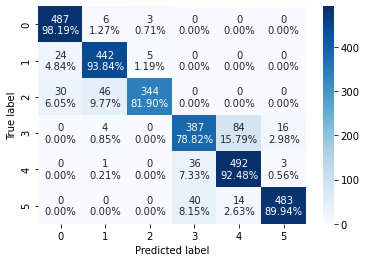

K: 6
F1 Macro score using StandardScaler: 0.884924966626102
F1 Macro score using QuantileTransformer: 0.9001286361157984


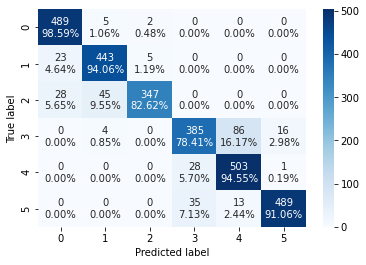

K: 8
F1 Macro score using StandardScaler: 0.885778653954131
F1 Macro score using QuantileTransformer: 0.9066756266523832


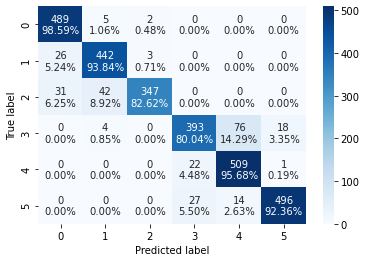

K: 10
F1 Macro score using StandardScaler: 0.8875890295449381
F1 Macro score using QuantileTransformer: 0.9092654960437176


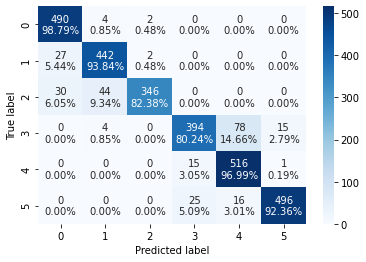

K: 12
F1 Macro score using StandardScaler: 0.8868123177938547
F1 Macro score using QuantileTransformer: 0.9080698251135607


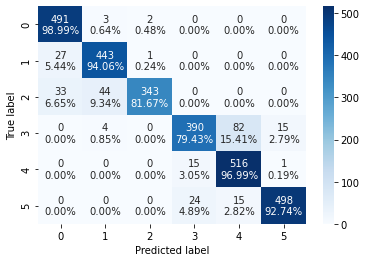

K: 14
F1 Macro score using StandardScaler: 0.888381562555412
F1 Macro score using QuantileTransformer: 0.9074087560850409


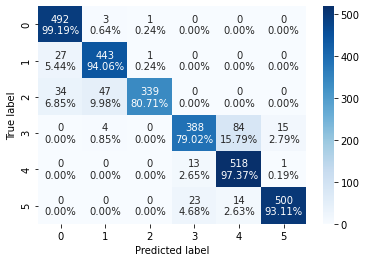

K: 16
F1 Macro score using StandardScaler: 0.8887085816255205
F1 Macro score using QuantileTransformer: 0.9082609122300855


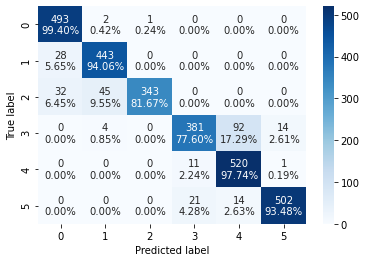

K: 18
F1 Macro score using StandardScaler: 0.8887960519175682
F1 Macro score using QuantileTransformer: 0.9084003715650754


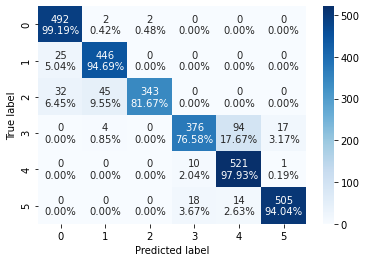

K: 20
F1 Macro score using StandardScaler: 0.885523141132622
F1 Macro score using QuantileTransformer: 0.9070341856767463


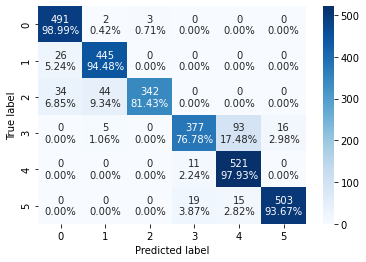

K: 22
F1 Macro score using StandardScaler: 0.8853553116072536
F1 Macro score using QuantileTransformer: 0.9051583494268681


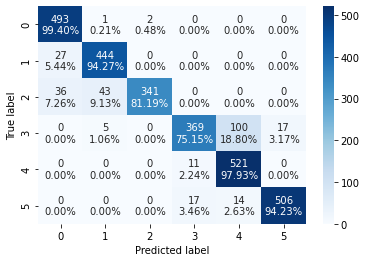

K: 24
F1 Macro score using StandardScaler: 0.8877271140176051
F1 Macro score using QuantileTransformer: 0.9037908033998331


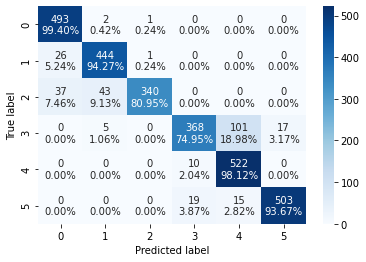

In [12]:
scorer = make_scorer(macro_f1_score, greater_is_better=True)
n_neighbors_arr = range(2, 25, 2)

metrics = []

for n_neighbors in n_neighbors_arr:
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights="distance",
        n_jobs=-1
    )
    model.fit(x_train_norm, y_train)
    y_pred = model.predict(x_test_norm)
    cm = confusion_matrix(y_test, y_pred)
    metric = macro_f1_score(y_test, y_pred)
    
    model.fit(x_train_norm_qtl, y_train)
    y_pred = model.predict(x_test_norm_qtl)
    cm_qtl = confusion_matrix(y_test, y_pred)
    metric_qtl = macro_f1_score(y_test, y_pred)
    
    metrics.append([n_neighbors, metric, metric_qtl, model])
    
    print("="*100)
    print("K:", n_neighbors)
    print("F1 Macro score using StandardScaler:", metric)
    print("F1 Macro score using QuantileTransformer:", metric_qtl)
    make_confusion_matrix(cm_qtl, sum_stats=False)
    plt.show()
#     print(cm_qtl, end="\n\n")
columns=["K", "F1 Macro score", "F1 Macro score (quantile)", "model"]
metrics = pd.DataFrame(metrics, columns=columns)


Como dito, a métrica medida para o KNN ao se utilizar os dados normalizados por transformação de quantil sempre é melhor.

Pode-se verificar que as classes 2 e 3 são na maioria das vezes as classes com menor acurácia, pois os modelos frequentemente as confundem com outras classes (a classe 2 é confundida pelas classes 0 e 1, enquanto a classe 3 é confundida pela classe 4).

Também percebe-se que por vezes a classe 1 é confundida com a classe 0. Menos comumente, as classes 4 e 5 são confundidos pela classe 3.

As classes 0, 1 e 4 são, na média, as classes que os modelos menos se confundem, tendo então a maior precisão. 

A tabela a seguir mostra os 5 melhores resultados obtidos utilizando o modelo KNN, com as métricas dos modelos utilizando os dados normalizados por média e desvio padrão, e utilizando a transformação de quantile. Conclui-se que o melhor K foi $K=10$, alcançando uma valor de F-score macro de 0.9092.

In [13]:
best_five = metrics.sort_values(by=metrics.columns[2], ascending=False).head()
best = best_five.iloc[0, :]
best_five

,K,F1 Macro score,F1 Macro score (quantile),model
4,10,0.887589,0.909265,"KNeighborsClassifier(n_jobs=-1, n_neighbors=10..."
8,18,0.888796,0.908400,"KNeighborsClassifier(n_jobs=-1, n_neighbors=18..."
7,16,0.888709,0.908261,"KNeighborsClassifier(n_jobs=-1, n_neighbors=16..."
5,12,0.886812,0.908070,"KNeighborsClassifier(n_jobs=-1, n_neighbors=12..."
6,14,0.888382,0.907409,"KNeighborsClassifier(n_jobs=-1, n_neighbors=14..."


Apesar de encontrarmos o valor ótimo de K, o modelo de K-nearest neighbors ainda tem a métrica 4 pontos percentuais pior que a regressão logística, que inclusive não teve hiperparâmetros otimizados como o KNN teve. Isto indica que o modelo de Regressão Logística utilizado é a melhor escolha para este problema.

Analisando a matriz de confusão, pode-se dizer que a solução baseada em regressão logística foi melhor na métrica escolhida principalmente por errar menos as classe 2 e 3, que foi a grande causa da performance pior do algoritmo KNN. 